[Point]  i ≈ 72.76 deg
[MC]     i = 72.80 deg (68%: 69.82–75.69; 95%: 66.73–78.38)  N=200000
[MC] i = 72.80 deg (68%: 69.82–75.69; 95%: 66.73–78.38)


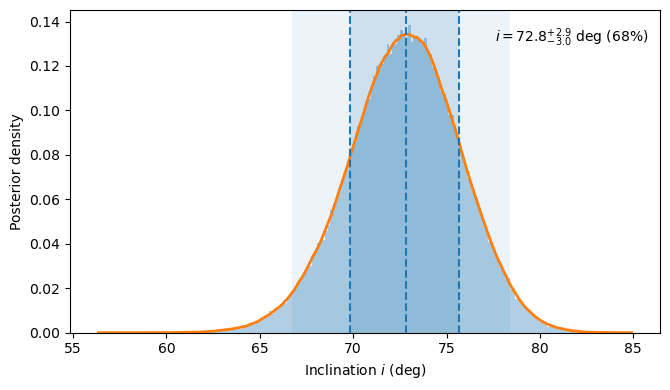

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
i.py — Infer inclination i from Gaia Thiele–Innes (A,B,F,G) with MC error propagation.
"""

import numpy as np

# =========================
# 0) Fill in your ABFG and uncertainties
# =========================
A_mu = -0.3994039967091388
B_mu = -0.38788203368050644
F_mu = -0.11993179119917557
G_mu = -0.9389152939085285

# If only 1σ errors are available and correlations are unknown: use these four; code will use a diagonal covariance
sigma_A = 0.024254577
sigma_B = 0.106109835
sigma_F = 0.053238407
sigma_G = 0.055105410

# If you have the full 4×4 covariance matrix for (A,B,F,G) (recommended), replace here:
C_full = None
# Example:
# C_full = np.array([
#     [sigma_A**2,  ... , ... , ...],
#     [ ...       , ... , ... , ...],
#     [ ...       , ... , ... , ...],
#     [ ...       , ... , ... , ...],
# ], dtype=float)


# ============ Utilities ============
def solve_cosi_from_TI(A, B, F, G):
    """
    Compute cos(i) from TI invariants that depend only on direction:
        R = (A*G - B*F) / (A^2 + B^2 + F^2 + G^2) = cos i / (1 + cos^2 i)
        => R cos^2 i - cos i + R = 0
    Return the physically admissible root (|cos i| <= 1).
    """
    AG, BF = A * G, B * F
    S = A * A + B * B + F * F + G * G
    R = (AG - BF) / S

    disc = np.maximum(0.0, 1.0 - 4.0 * R * R)
    # Two algebraic roots
    r1 = (1.0 - np.sqrt(disc)) / (2.0 * R)
    r2 = (1.0 + np.sqrt(disc)) / (2.0 * R)

    # Robust handling for R ≈ 0: cos i ≈ R
    eps = 1e-12
    r1 = np.where(np.abs(R) < eps, R, r1)
    r2 = np.where(np.abs(R) < eps, R, r2)

    # Choose a physical root: prefer the one with |cos i|<=1; if both valid, keep r1 consistently
    ok1 = np.isfinite(r1) & (np.abs(r1) <= 1.0)
    ok2 = np.isfinite(r2) & (np.abs(r2) <= 1.0)
    cosi = np.where(ok1, r1, r2)
    return np.clip(cosi, -1.0, 1.0)


def deg(x):
    """Radians to degrees via arccos of cos(i)"""
    return np.degrees(np.arccos(x))


if __name__ == "__main__":
    # =========================
    # 1) Point estimate using only direction (no errors)
    # =========================
    i_deg_point = deg(solve_cosi_from_TI(A_mu, B_mu, F_mu, G_mu))
    print(f"[Point]  i ≈ {i_deg_point:.2f} deg")

    # =========================
    # 2) Monte Carlo uncertainty propagation
    # =========================
    N = 200_000
    rng = np.random.default_rng(42)

    mu = np.array([A_mu, B_mu, F_mu, G_mu], dtype=float)
    if C_full is None:
        C_full = np.diag([sigma_A**2, sigma_B**2, sigma_F**2, sigma_G**2])

    ABFG = rng.multivariate_normal(mean=mu, cov=C_full, size=N)  # (N,4)
    A, B, F, G = ABFG.T

    # — Direction only: normalize each (A,B,F,G) sample —
    norm = np.linalg.norm(ABFG, axis=1, keepdims=True)
    ABFG_u = ABFG / norm
    Au, Bu, Fu, Gu = ABFG_u.T

    cosi_samps = solve_cosi_from_TI(Au, Bu, Fu, Gu)
    i_deg_samps = deg(cosi_samps)

    # Quantiles
    q = np.percentile
    i50 = q(i_deg_samps, 50)
    i16, i84 = q(i_deg_samps, 16), q(i_deg_samps, 84)
    i025, i975 = q(i_deg_samps, 2.5), q(i_deg_samps, 97.5)

    print(
        f"[MC]     i = {i50:.2f} deg "
        f"(68%: {i16:.2f}–{i84:.2f}; 95%: {i025:.2f}–{i975:.2f})  N={N}"
    )

import numpy as np
import matplotlib.pyplot as plt



q = np.percentile
i16, i50, i84 = q(i_deg_samps, [16, 50, 84])
i025, i975 = q(i_deg_samps, [2.5, 97.5])

print(f"[MC] i = {i50:.2f} deg "
      f"(68%: {i16:.2f}–{i84:.2f}; 95%: {i025:.2f}–{i975:.2f})")


fig, ax = plt.subplots(figsize=(6.8, 4.0))


bins = max(60, min(200, int(np.sqrt(i_deg_samps.size) / 2)))
vals, edges, _ = ax.hist(i_deg_samps, bins=bins, density=True, alpha=0.35)

centers = 0.5 * (edges[:-1] + edges[1:])
if len(vals) >= 5:
    w = 7
    smooth = np.convolve(vals, np.ones(w)/w, mode='same')
    ax.plot(centers, smooth, linewidth=2)


ax.axvspan(i16,  i84,  alpha=0.15)
ax.axvspan(i025, i975, alpha=0.08)


for x in (i16, i50, i84):
    ax.axvline(x, linestyle='--', linewidth=1.5)


ax.set_xlabel(r"Inclination $i$ (deg)")
ax.set_ylabel("Posterior density")
ax.text(0.98, 0.95,
        rf"$i = {i50:.1f}^{{+{i84-i50:.1f}}}_{{-{i50-i16:.1f}}}$ deg (68%)"+"\n",
        ha='right', va='top', transform=ax.transAxes)

fig.tight_layout()

fig.savefig("i_posterior.png", dpi=300)
plt.show()